## Brain MRI Tumor Classification using vgg16

# Important liberals

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import kagglehub
import shutil
import os

## Data Loading

In [ ]:
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
print("Downloaded dataset path:", path)

destination = "/content/brain_mri_data"

if not os.path.exists(destination):
    shutil.copytree(path, destination)
    print(f"Dataset copied to: {destination}")
else:
    print("Destination folder already exists.")

Downloaded dataset path: /kaggle/input/brain-mri-images-for-brain-tumor-detection
Destination folder already exists.


In [ ]:
dataset_path = "/content/brain_mri_data/brain_tumor_dataset"

batch_size = 32
img_size = (224, 224)

train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [ ]:
class_names = dataset.class_names
print(class_names)

['no', 'yes']


##Data Preprocessing

In [ ]:
class_names = train_ds.class_names
print("classes:", class_names)

import collections

def count_classes(ds):
    count = collections.Counter()
    for images, labels in ds.unbatch():
        count[int(labels.numpy())] += 1
    return count

print("train:", count_classes(train_ds))
print("val:", count_classes(val_ds))

classes: ['no', 'yes']
train: Counter({1: 123, 0: 80})
val: Counter({1: 32, 0: 18})


In [ ]:
train_labels = []
for images, labels in train_ds.unbatch():
    train_labels.append(labels.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(1.26875), 1: np.float64(0.8252032520325203)}


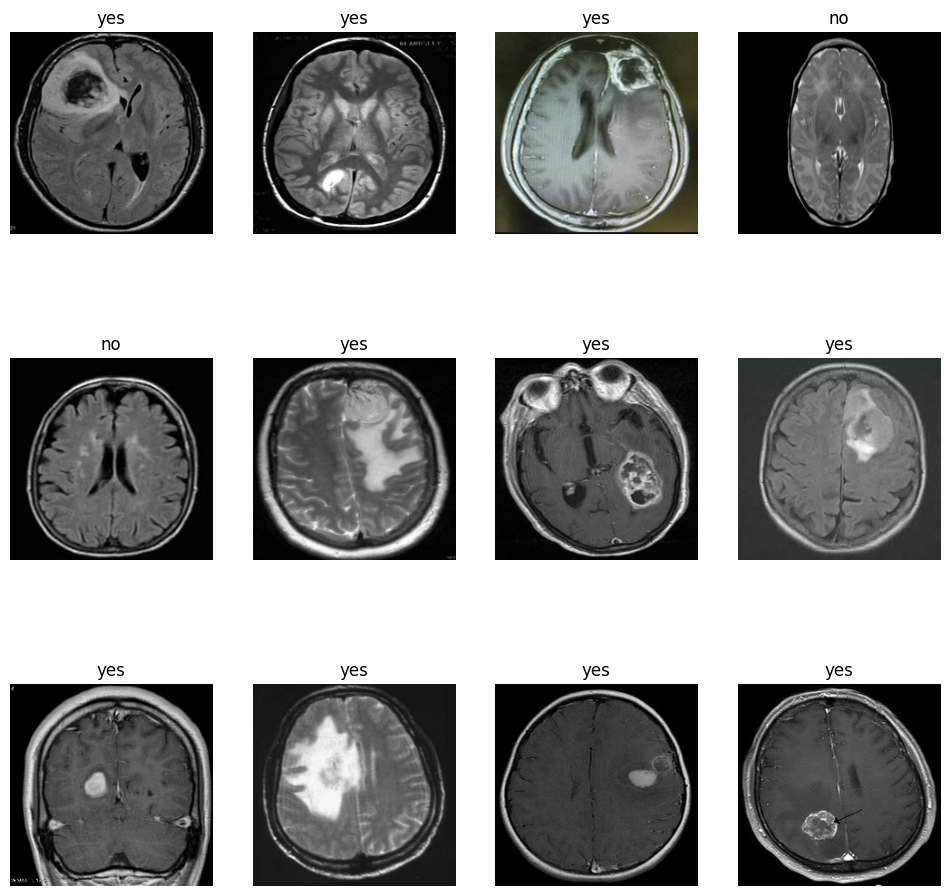

In [ ]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

##Model Architecture

In [ ]:
vgg16_base = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
vgg16_base.trainable = False

In [ ]:
model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    vgg16_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(4096, activation="relu"),
    layers.Dense(4096, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

In [ ]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601,345 (128.18 MB)

 Trainable params: 18,886,657 (72.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

##Model Training

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

In [ ]:
early = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=6,
    verbose=1,
    mode='auto'
)

callbacks = [checkpoint, early]

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4596 - loss: 24.2700
Epoch 1: val_accuracy improved from -inf to 0.36000, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 485ms/step - accuracy: 0.4649 - loss: 23.5910 - val_accuracy: 0.3600 - val_loss: 1.2415
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5697 - loss: 0.7672
Epoch 2: val_accuracy improved from 0.36000 to 0.58000, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 714ms/step - accuracy: 0.5767 - loss: 0.7552 - val_accuracy: 0.5800 - val_loss: 1.0156
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7966 - loss: 0.4830
Epoch 3: val_accuracy improved from 0.58000 to 0.72000, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - accuracy: 0.7962 - loss: 0.4855 - val_accuracy: 0.7200 - val_loss: 0.5953
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8273 - loss: 0.3487
Epoch 4: val_accuracy improved from 0.72000 to 0.

##Evaluation

In [ ]:
model.evaluate(val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9525 - loss: 0.2721


[0.2396811544895172, 0.9599999785423279]

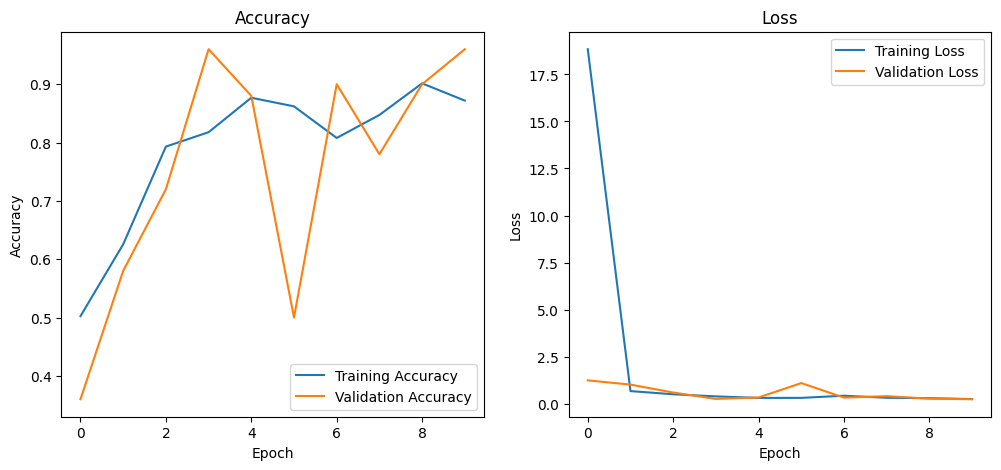

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)